In [205]:
from scipy.linalg import eigh_tridiagonal

import numpy as np
import matplotlib.pyplot as plt

from jupyterthemes import jtplot
jtplot.style(theme='monokai', context='notebook', ticks=True, grid=True)

np.set_printoptions(precision=3, suppress=True)

In [206]:
def get_bloch_spectrum(V0, kl, q, l_max):
    l = np.arange(-l_max, l_max+1)
    return eigh_tridiagonal((2 * l + q/kl) ** 2 + V0/2, -V0/4 * np.ones(len(l) - 1))

In [284]:
V0, kl = 0, np.pi #potential depth, period

In [285]:
l_max = 10
q = np.linspace(-np.pi, np.pi, 100)

psi = np.empty((len(q), 2 * l_max + 1, 2 * l_max + 1), dtype = np.complex128)
E = np.empty((len(q), 2 * l_max + 1))

for i, k in enumerate(q):
    E[i], psi[i] = get_bloch_spectrum(V0, kl, k, l_max)

In [286]:
# # k is index of wave-number
def to_pos_basis(phi_l, kl, l_max):
    l = np.arange(-l_max, l_max+1)
    def phi_x(x):
        return (1/np.sqrt(2 * np.pi)) * np.sum(phi_l * np.exp(2j * kl * x * l))
    
    return phi_x
    
def func_wannier(bloch_fn, k, R):
    N = len(k)
    def func(x):
        bloch_vals = np.array([fn(x) for fn in bloch_fn])
        return 1/np.sqrt(N) * np.sum(bloch_vals * np.exp(1j * k * (x - R)), axis = 0)

    return func

In [287]:
bloch = [to_pos_basis(f.T[0], kl, l_max) for f in psi]
wannier = func_wannier(bloch, q, -1)

x = np.linspace(-3, 3, 1001) #domain
V = V0 * np.sin(np.pi * x) ** 2

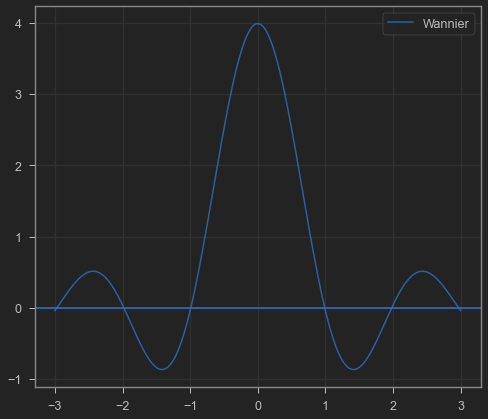

In [290]:
plt.plot(x, np.real(np.vectorize(func_wannier(bloch, q, 0))(x)), label = f"Wannier", alpha = 0.75)
# plt.plot(x, np.abs(np.vectorize(psi_x[0])(x))**2, label = "Bloch (q = 0)")
plt.ticklabel_format(useOffset=False, style='plain')
plt.axhline(0)
plt.legend()